# ARMA task
Learn an autoregressive moving average model (see Wikipedia for an introduction if unfamiliar) for at least 5 individual sensors (pick them in a sensible way!). Most statistical packages (R, statsmodels in Python) contain standard algorithm for fitting these models from training data. Use autocorrelation plots in order to identify the order of the ARMA models. The parameters can be determined using Akaike’s Information Criterion (AIC) or another model selection method. Note that there exists a wide range of ARMA variants; you only have to use the basic model.

Decide how to set the detection threshold sensibly. Study some of the anomalies detected anomalies. What kind of anomalies can you detect using ARMA models? Which sensors can be modeled effectively using ARMA?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

In [29]:
def parse_date(x):    
    date = str(x).split(' ')[0]
    time_stamp = pd.datetime.strptime(date,'%d/%m/%y')
    return time_stamp
df_1 = pd.read_csv('BATADAL_dataset_training_1.csv',parse_dates=[0],date_parser=parse_date, skipinitialspace=True)
df_2 = pd.read_csv('BATADAL_dataset_training_2.csv',parse_dates=[0],date_parser=parse_date, skipinitialspace=True)
df_3 = pd.read_csv('BATADAL_test_dataset.csv',parse_dates=[0],date_parser=parse_date, skipinitialspace=True)

df_2["ATT_FLAG"] = np.where((df_2["ATT_FLAG"]==-999), 0, 1)

tank_features = ['L_T1', 'L_T2', 'L_T3', 'L_T4', 'L_T7']
pump_features = ['F_PU1', 'F_PU2', 'F_PU4', 'F_PU6', 'F_PU7', 'F_PU8', 'F_PU10', 'F_PU11']
valve_features = ['F_V2']
junctions_features = ['P_J280', 'P_J269', 'P_J300', 'P_J256', 'P_J289', 'P_J302', 'P_J306', 'P_J307', 'P_J317', 'P_J14', 'P_J422']

## Check autocorrelation
Apply Durbin Watson test to examine autocorrelation in the data. The test will return a value between 0 and 4.
- A value of 2.0 means there is no autocorrelation detected in the sample. 
- Values from zero to 2.0 indicate positive autocorrelation.
- Values from 2.0 to 4.0 indicate negative autocorrelation.

In [36]:
for feature in tank_features:
    score = sm.stats.durbin_watson(df_1[feature])
    print('FEATURE: %s, DW score: %.3f' % (feature, score))

FEATURE: L_T1, DW score: 0.006
FEATURE: L_T2, DW score: 0.016
FEATURE: L_T3, DW score: 0.008
FEATURE: L_T4, DW score: 0.016
FEATURE: L_T5, DW score: 0.029
FEATURE: L_T6, DW score: 0.001
FEATURE: L_T7, DW score: 0.039


## Identifying the order of differencing(d)

Check if the series is stationary using the Augmented Dickey Fuller test.

If p-value of the test is less than 0.05, then reject the null hypothesis and infer that the time series is indeed stationary. Otherwise the time series is non-stationary and needs differencing.

In [35]:
for feature in tank_features:
    result = adfuller(df_1[feature].dropna())
    print('FEATURE: %s, ADF Statistic: %f, p-value: %f ' % (feature, result[0], result[1]))

FEATURE: L_T1, ADF Statistic: -20.615633, p-value: 0.000000 
FEATURE: L_T2, ADF Statistic: -18.612726, p-value: 0.000000 
FEATURE: L_T3, ADF Statistic: -14.375782, p-value: 0.000000 
FEATURE: L_T4, ADF Statistic: -16.582866, p-value: 0.000000 
FEATURE: L_T5, ADF Statistic: -18.509403, p-value: 0.000000 
FEATURE: L_T6, ADF Statistic: -18.364822, p-value: 0.000000 
FEATURE: L_T7, ADF Statistic: -17.489711, p-value: 0.000000 


## Diagnosing ACF and PACF plots

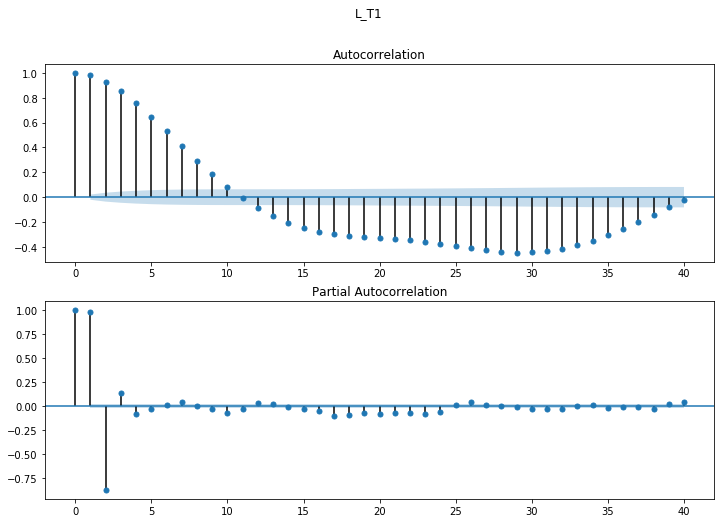

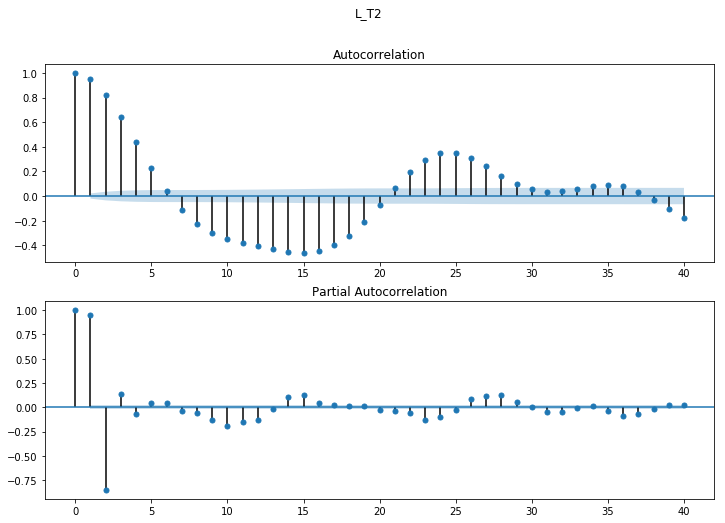

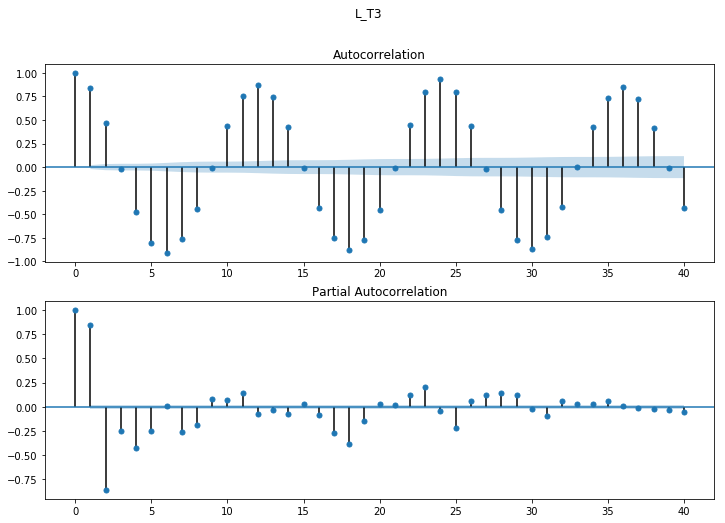

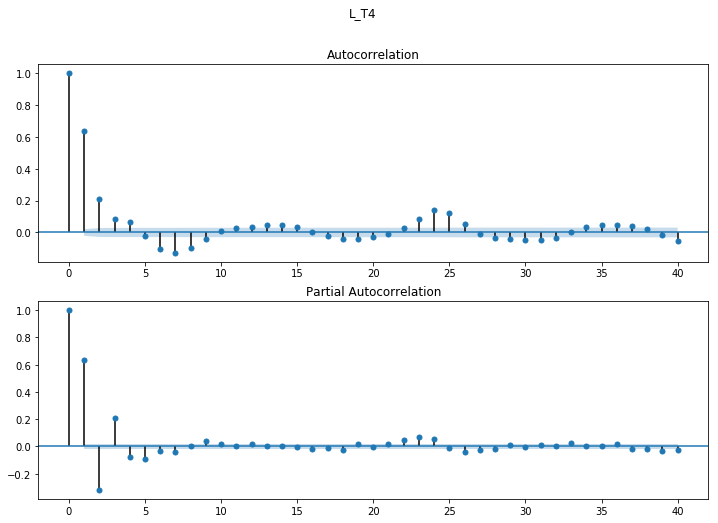

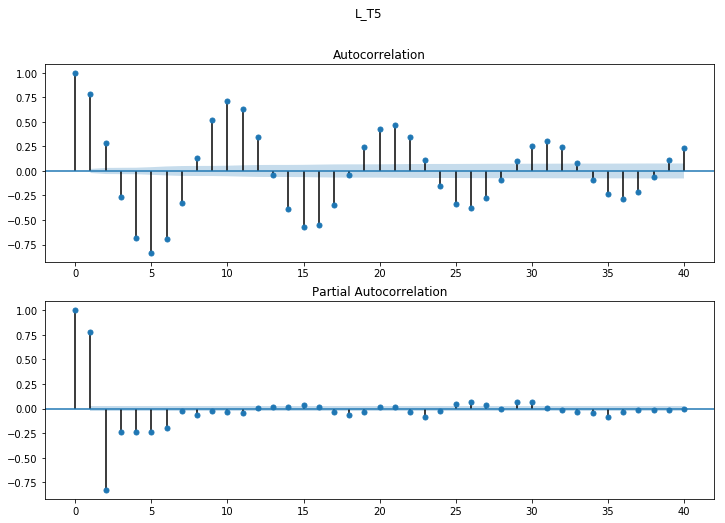

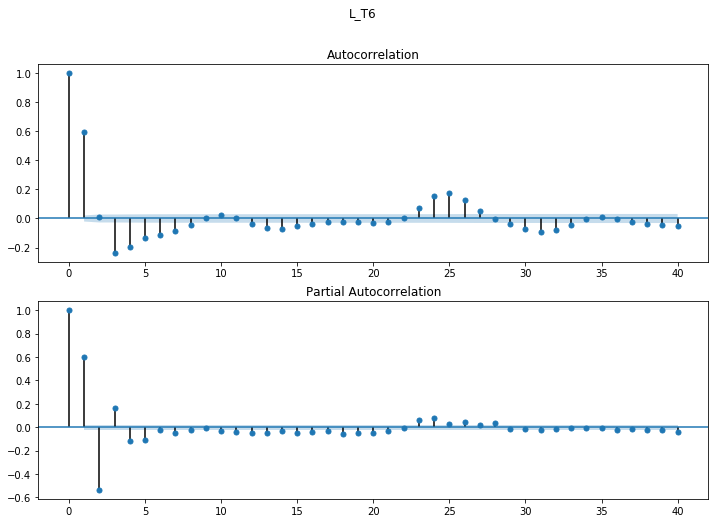

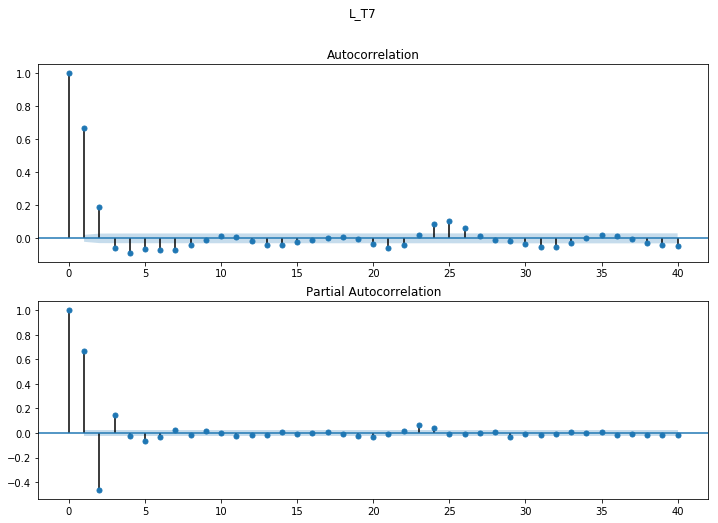

In [37]:
def plot_acf_pacf(feature_name):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(df_1[feature_name], lags=40, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(df_1[feature_name], lags=40, ax=ax2)
    fig.suptitle(feature_name, fontsize="large")
    plt.savefig("fig/acf/" + feature_name)
    plt.show()

for feature in tank_features:
    plot_acf_pacf(feature)

### Applying ARIMA

In [22]:
# Predict a single value
def predict(coef, arr):
    yhat = 0.0
    for i in range(1, len(coef) + 1):
        yhat += coef[i - 1] * arr[-i]
#         print("arr[-%d]=%f" % (i, arr[-i]))
    return yhat

# Concatenate list
def prepare(preset, history):
    for i in range(len(preset)):
        history.append(preset[i])
    return history

# Prepare list to plot
def prepare_plot_list(anomaly, length, p):
    result = np.zeros(length)
    
    for i in anomaly:
        result[i-p] = 1

    return result

# Plot detected vs actual
def plot_detection(detected, actual, feature):
    plt.figure(figsize=(10,2))
    plt.plot(detected, label='Predicted')
    plt.plot(actual, label='Actual')
    plt.title('ARMA attack detection on ' + feature)
    plt.legend()
    plt.savefig('fig/detection/' + feature)
    plt.show()

# Get confusion matrix
def confusion_matrix(label, detected, p):
    tp, fp, fn = list(), list(), list()
    
    for i in detected:
        if(label[i] == 1):
            tp.append(i)
        else:
            fp.append(i)
    
    for i in range(p, len(label) + p):
        if(label[i] == 1):
            if((i-p) not in detected):
                fn.append(i)
    
    return [tp, fp, fn]

In [23]:
# Grid search to find optimal parameters for ARMA model
def grid_search(feature):
    f = open("log/grid_search.txt", "a")
    f.write("-------- " + feature + "---------\n")
    print("---------- FEATURE: " + feature + " ---------\n")

    # Iterate over every combination
    best_order = None
    best_score = float('Inf')
    for p in [1, 2, 4]:
        for q in [1, 2, 4]:
            order = (p, 0, q)
            try:
                model = ARIMA(df_1[feature], order=order)
                model_fit = model.fit(disp=0, trend='nc')
                aic = model_fit.aic
#                 print('ARIMA%s AIC=%.3f' % (order,aic))
                f.write('ARIMA%s AIC=%.3f\n' % (order,aic))

                # Select model with low aic score
                if (aic < best_score):
                    best_order = order
                    best_score = aic
            except:
                continue
    
    print('Best ARIMA%s AIC=%.3f' % (best_order, best_score))
    f.write('Best ARIMA%s AIC=%.3f\n' % (best_order, best_score))
    f.close()
    return best_order

# Get the threshold from training data
def train_threshold(train, history, p, ar_coef, ma_coef, residuals, feature):   
    prediction = list()
    
    for i in range(p, len(train)+p):
        yhat = predict(ar_coef, history) + predict(ma_coef, residuals) + history[-1]
        observed = train[i]
        history.append(observed)
        error = abs(yhat-observed)
        residuals.append(error)
        prediction.append(yhat)
#         print('predicted=%.3f, observed=%.3f, previous=%.3f, residual=%.3f' % (yhat, observed, history[-2], error))
    
    # Plot prediction vs actual
    plt.figure(figsize=(15,2))
    plt.plot(prediction, label='prediction')
    plt.plot(train, label='actual')
    plt.legend()
    plt.title("ARMA prediction of " + feature)
    plt.savefig("fig/prediction/" + feature)
    plt.show()
    
    threshold = max(residuals) * 0.95
    return threshold


# Predict anomalies
def predict_anomaly(threshold, history, test, p, ar_coef, ma_coef, residuals, feature, label):  
    anomaly, prediction = list(), list()
    
    for i in range(p, len(test)+p):
        yhat = predict(ar_coef, history) + predict(ma_coef, residuals) + history[-1]
        observed = test[i]
        history.append(observed)
        error = abs(yhat-observed)
        residuals.append(error)
        prediction.append(yhat)
#         print('predicted=%.3f, observed=%.3f, previous=%.3f, residual=%.3f' % (yhat, observed, history[-2], error))
        
        # Identify an anomaly if the error is over threshold
        if error > threshold:
            anomaly.append(i)
            print('DETECTED residual=%.3f at t=%d' % (error, i))
    
    print(anomaly)
    
    # Plot detected vs actual
    detected = prepare_plot_list(anomaly, len(test), p)
    plot_detection(detected, label, feature)
    
    # Get confusion matrix
    [tp, fp, fn] = confusion_matrix(label, anomaly, p)
#     print('tp = %d, fp = %d' % (tp, fp))
    precision = len(tp) / (len(tp) + len(fp) + 0.001)
    recall = len(tp) / (len(tp) + len(fn) + 0.001)
    print("TP: count = %d, list = %s" % ( len(tp)," ".join(str(x) for x in tp)))
    print("FP: count = %d, list = %s" % ( len(fp)," ".join(str(x) for x in fp)))
    print("FN: count = %d" % len(fn))
    print("precision = %.6f, recall = %.6f" % (precision, recall))
    
    # Save result to file
    f = open("log/detection.txt", "a")
    f.write("Feature: %s, threshold: %.3f\n" % (feature, threshold))
    f.write("Detected: " + " ".join(str(x) for x in anomaly) + "\n")
    f.write("TP: count = %d, list = %s\n" % (len(tp), " ".join(str(x) for x in tp)))
    f.write("FP: count = %d, list = %s\n" % (len(fp), " ".join(str(x) for x in fp)))
    f.write("FN: count = %d\n" % len(fn))
    f.write("precision = %.6f, recall = %.6f\n\n" % (precision, recall))
    f.close()

In [24]:
def pipeline(features):
    for feature in features:
        training_data = df_1[feature]
        testing_data = df_3[feature]
        
        # Find best parameter for ARMA
        order = grid_search(feature)
        p = order[0]
        
        # Build ARMA model
        model = ARIMA(df_1[feature], order=order)
        model_fit = model.fit(disp=0)
        ar_coef = model_fit.arparams
        ma_coef = model_fit.maparams
        residuals = model_fit.resid.tolist()
        
        # Get threshold from training data
        pretrain, train = training_data[0:p], training_data[p:]
        history = prepare(pretrain.tolist(), training_data.tolist())
        threshold = train_threshold(train, history, p, ar_coef, ma_coef, residuals, feature)
        
        # Test anomaly on testing set
        pretest, test, label = testing_data[0:p], testing_data[p:], df_3['ATT_FLAG'][p:]
        history = prepare(pretest.tolist(), history)
        predict_anomaly(threshold, history, test, p, ar_coef, ma_coef, residuals, feature, label)
        

---------- FEATURE: L_T1 ---------



D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Best ARIMA(4, 0, 1) AIC=-13202.752


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


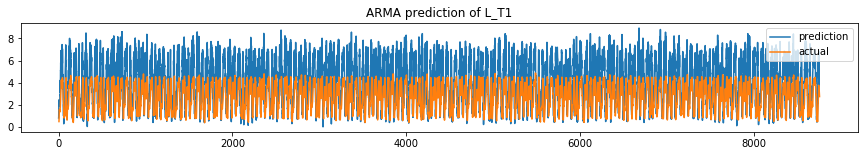

DETECTED residual=4.335 at t=945
DETECTED residual=4.260 at t=947
[945, 947]


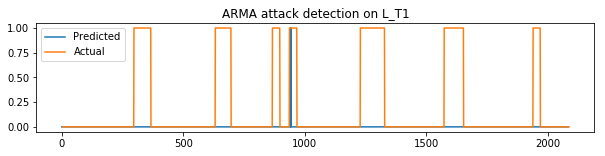

TP: count = 2, list = 945 947
FP: count = 0, list = 
FN: count = 405
precision = 0.999500, recall = 0.004914
---------- FEATURE: L_T2 ---------



D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Best ARIMA(4, 0, 4) AIC=-294.163


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


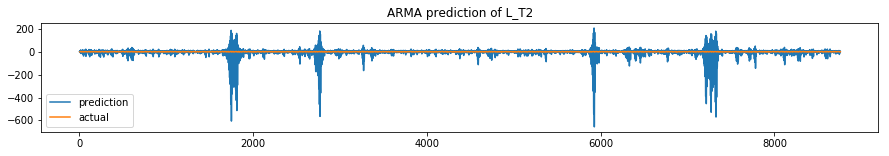

[]


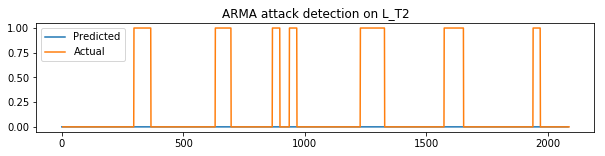

TP: count = 0, list = 
FP: count = 0, list = 
FN: count = 407
precision = 0.000000, recall = 0.000000
---------- FEATURE: L_T3 ---------



D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Best ARIMA(4, 0, 4) AIC=-7357.263


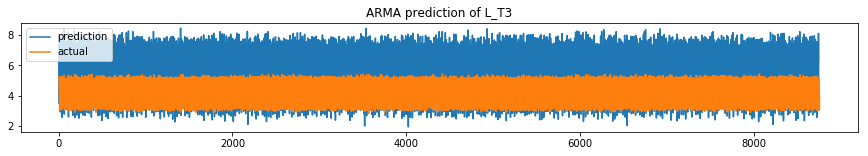

DETECTED residual=3.413 at t=339
DETECTED residual=3.311 at t=496
DETECTED residual=3.406 at t=712
DETECTED residual=3.312 at t=1072
DETECTED residual=3.433 at t=1289
[339, 496, 712, 1072, 1289]


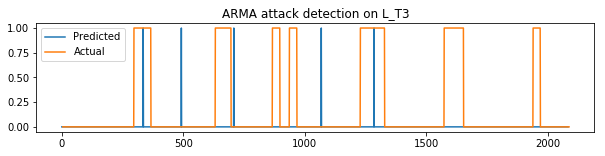

TP: count = 2, list = 339 1289
FP: count = 3, list = 496 712 1072
FN: count = 405
precision = 0.399920, recall = 0.004914
---------- FEATURE: L_T4 ---------



D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Best ARIMA(4, 0, 2) AIC=8233.597


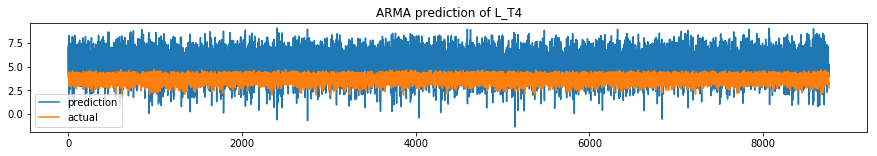

DETECTED residual=5.930 at t=569
[569]


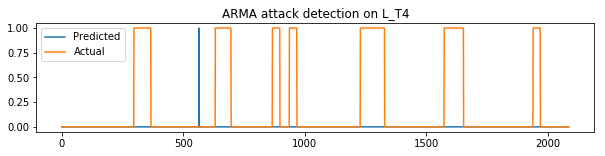

TP: count = 0, list = 
FP: count = 1, list = 569
FN: count = 407
precision = 0.000000, recall = 0.000000
---------- FEATURE: L_T7 ---------



D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Best ARIMA(4, 0, 1) AIC=14103.994


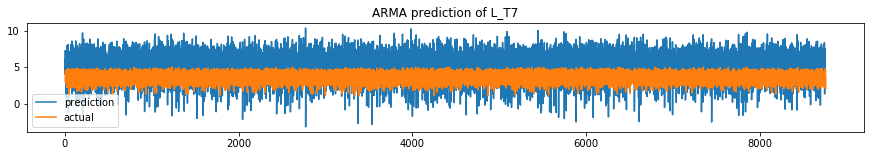

[]


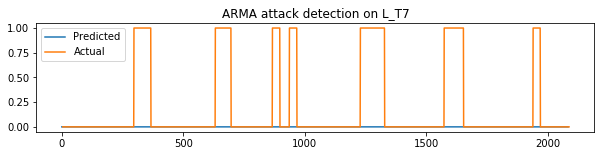

TP: count = 0, list = 
FP: count = 0, list = 
FN: count = 407
precision = 0.000000, recall = 0.000000


In [30]:
# Apply ARMA on tank sensors
pipeline(tank_features)

---------- FEATURE: F_PU1 ---------



D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Best ARIMA(2, 0, 4) AIC=51634.996


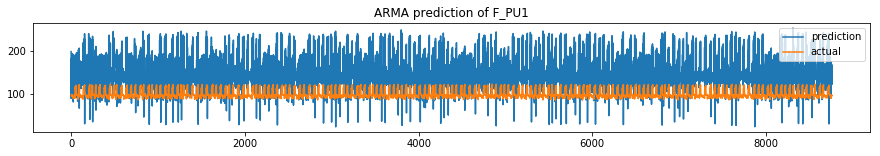

DETECTED residual=141.328 at t=45
DETECTED residual=142.756 at t=239
DETECTED residual=192.997 at t=946
DETECTED residual=199.825 at t=947
DETECTED residual=204.671 at t=948
DETECTED residual=205.475 at t=949
DETECTED residual=203.637 at t=950
DETECTED residual=201.346 at t=951
DETECTED residual=198.763 at t=952
DETECTED residual=196.085 at t=953
DETECTED residual=193.401 at t=954
DETECTED residual=287.473 at t=955
DETECTED residual=141.416 at t=1044
DETECTED residual=141.651 at t=1334
DETECTED residual=145.109 at t=1489
DETECTED residual=142.580 at t=1548
DETECTED residual=145.363 at t=1655
DETECTED residual=144.445 at t=1775
[45, 239, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 1044, 1334, 1489, 1548, 1655, 1775]


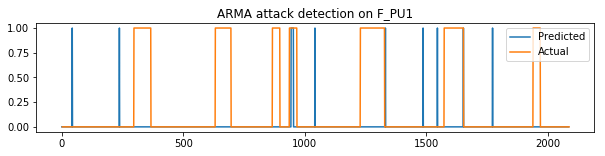

TP: count = 10, list = 946 947 948 949 950 951 952 953 954 955
FP: count = 8, list = 45 239 1044 1334 1489 1548 1655 1775
FN: count = 397
precision = 0.555525, recall = 0.024570
---------- FEATURE: F_PU2 ---------

Best ARIMA(1, 0, 2) AIC=76308.248


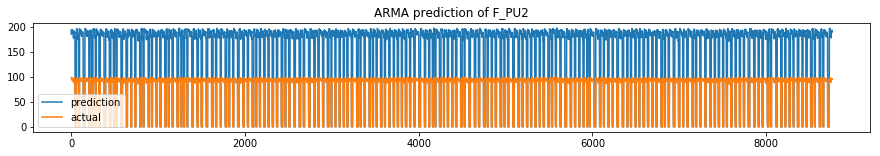

DETECTED residual=187.388 at t=32
DETECTED residual=180.550 at t=82
DETECTED residual=187.863 at t=175
DETECTED residual=183.367 at t=270
DETECTED residual=183.862 at t=381
DETECTED residual=180.626 at t=421
DETECTED residual=181.467 at t=468
DETECTED residual=180.365 at t=522
DETECTED residual=179.444 at t=583
DETECTED residual=183.130 at t=654
DETECTED residual=181.821 at t=698
DETECTED residual=180.076 at t=752
DETECTED residual=181.736 at t=856
DETECTED residual=179.296 at t=1027
DETECTED residual=183.094 at t=1139
DETECTED residual=183.713 at t=1196
DETECTED residual=179.661 at t=1281
DETECTED residual=180.326 at t=1429
DETECTED residual=181.454 at t=1476
DETECTED residual=180.367 at t=1591
DETECTED residual=182.815 at t=1644
DETECTED residual=179.928 at t=1700
DETECTED residual=180.176 at t=1812
DETECTED residual=179.478 at t=1863
DETECTED residual=179.646 at t=2009
[32, 82, 175, 270, 381, 421, 468, 522, 583, 654, 698, 752, 856, 1027, 1139, 1196, 1281, 1429, 1476, 1591, 1644, 170

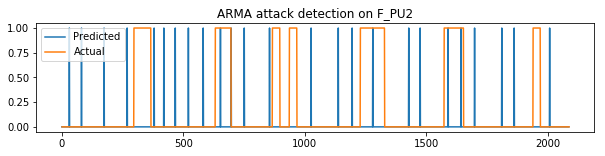

TP: count = 4, list = 654 1281 1591 1644
FP: count = 21, list = 32 82 175 270 381 421 468 522 583 698 752 856 1027 1139 1196 1429 1476 1700 1812 1863 2009
FN: count = 403
precision = 0.159994, recall = 0.009828
---------- FEATURE: F_PU4 ---------



D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Best ARIMA(4, 0, 4) AIC=64471.767


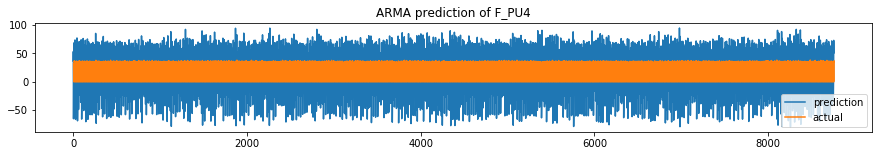

DETECTED residual=76.496 at t=246
DETECTED residual=76.576 at t=1107
DETECTED residual=78.807 at t=1109
DETECTED residual=78.245 at t=1254
DETECTED residual=80.630 at t=1373
[246, 1107, 1109, 1254, 1373]


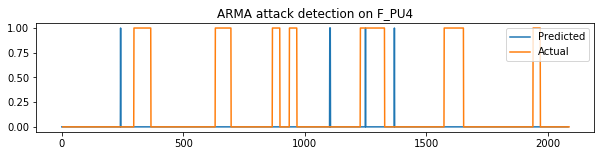

TP: count = 1, list = 1254
FP: count = 4, list = 246 1107 1109 1373
FN: count = 406
precision = 0.199960, recall = 0.002457
---------- FEATURE: F_PU6 ---------



D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Best ARIMA(1, 0, 2) AIC=28590.580


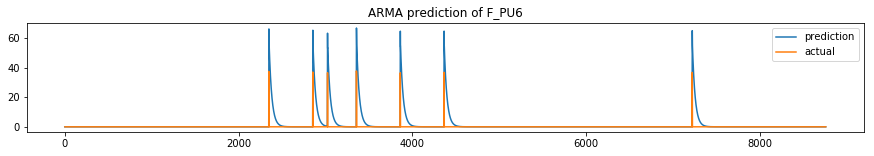

[]


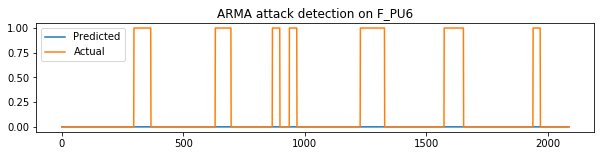

TP: count = 0, list = 
FP: count = 0, list = 
FN: count = 407
precision = 0.000000, recall = 0.000000
---------- FEATURE: F_PU7 ---------

Best ARIMA(2, 0, 4) AIC=74673.782


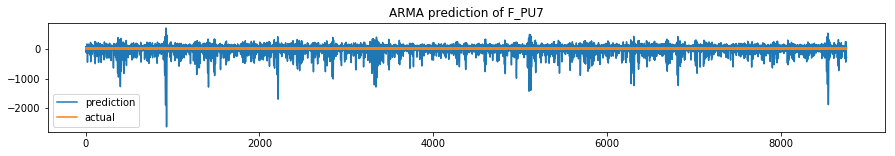

[]


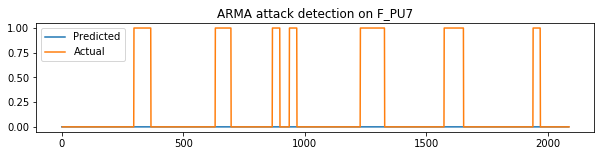

TP: count = 0, list = 
FP: count = 0, list = 
FN: count = 407
precision = 0.000000, recall = 0.000000
---------- FEATURE: F_PU8 ---------



D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Best ARIMA(4, 0, 4) AIC=67942.339


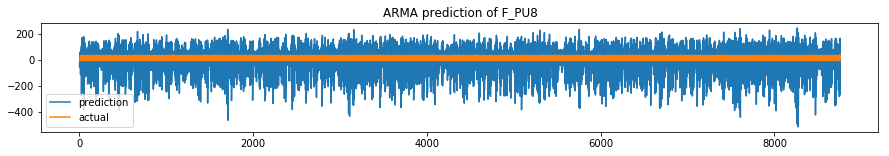

[]


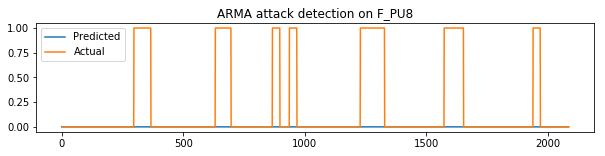

TP: count = 0, list = 
FP: count = 0, list = 
FN: count = 407
precision = 0.000000, recall = 0.000000
---------- FEATURE: F_PU10 ---------



D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Best ARIMA(2, 0, 4) AIC=66724.616


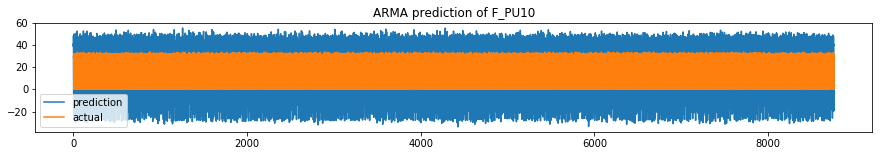

DETECTED residual=62.600 at t=43
DETECTED residual=62.980 at t=861
DETECTED residual=61.968 at t=942
DETECTED residual=62.349 at t=1531
DETECTED residual=63.595 at t=1579
DETECTED residual=63.595 at t=1627
DETECTED residual=61.771 at t=1758
DETECTED residual=62.391 at t=1862
[43, 861, 942, 1531, 1579, 1627, 1758, 1862]


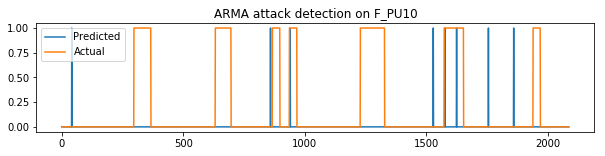

TP: count = 3, list = 942 1579 1627
FP: count = 5, list = 43 861 1531 1758 1862
FN: count = 404
precision = 0.374953, recall = 0.007371
---------- FEATURE: F_PU11 ---------



D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Best ARIMA(1, 0, 1) AIC=7081.515


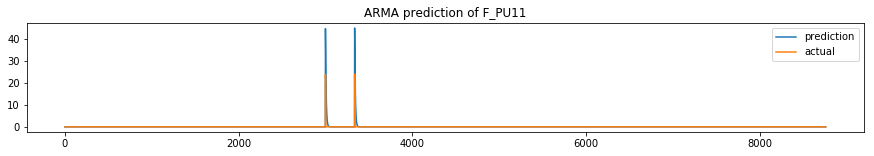

[]


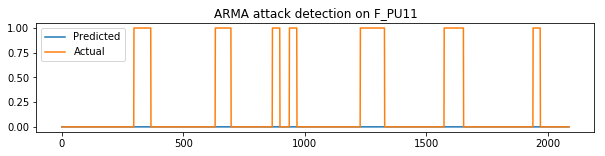

TP: count = 0, list = 
FP: count = 0, list = 
FN: count = 407
precision = 0.000000, recall = 0.000000


In [31]:
# Apply ARMA on pump sensors
pipeline(pump_features)

---------- FEATURE: F_V2 ---------

Best ARIMA(4, 0, 2) AIC=78334.981


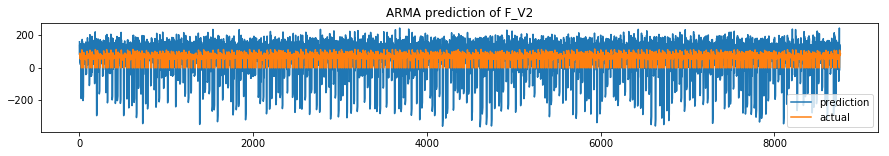

DETECTED residual=421.189 at t=1849
DETECTED residual=414.578 at t=2078
[1849, 2078]


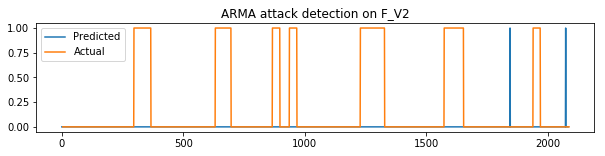

TP: count = 0, list = 
FP: count = 2, list = 1849 2078
FN: count = 407
precision = 0.000000, recall = 0.000000


In [32]:
# Apply ARMA on valve sensors
pipeline(valve_features)

---------- FEATURE: P_J280 ---------

Best ARIMA(1, 0, 1) AIC=-77557.262


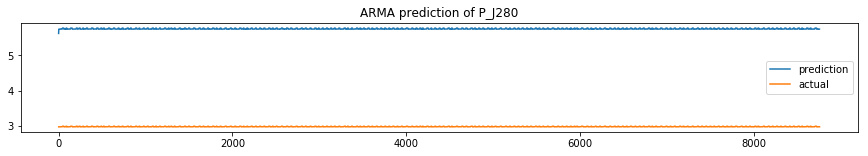

DETECTED residual=2.766 at t=1
DETECTED residual=2.756 at t=2
DETECTED residual=2.774 at t=3
DETECTED residual=2.775 at t=4
DETECTED residual=2.775 at t=5
DETECTED residual=2.775 at t=6
DETECTED residual=2.775 at t=7
DETECTED residual=2.775 at t=8
DETECTED residual=2.775 at t=9
DETECTED residual=2.785 at t=10
DETECTED residual=2.757 at t=11
DETECTED residual=2.774 at t=12
DETECTED residual=2.785 at t=13
DETECTED residual=2.757 at t=14
DETECTED residual=2.774 at t=15
DETECTED residual=2.775 at t=16
DETECTED residual=2.775 at t=17
DETECTED residual=2.775 at t=18
DETECTED residual=2.775 at t=19
DETECTED residual=2.775 at t=20
DETECTED residual=2.775 at t=21
DETECTED residual=2.775 at t=22
DETECTED residual=2.775 at t=23
DETECTED residual=2.775 at t=24
DETECTED residual=2.775 at t=25
DETECTED residual=2.775 at t=26
DETECTED residual=2.775 at t=27
DETECTED residual=2.775 at t=28
DETECTED residual=2.775 at t=29
DETECTED residual=2.775 at t=30
DETECTED residual=2.775 at t=31
DETECTED residual

DETECTED residual=2.775 at t=1756
DETECTED residual=2.775 at t=1757
DETECTED residual=2.775 at t=1758
DETECTED residual=2.775 at t=1759
DETECTED residual=2.765 at t=1760
DETECTED residual=2.784 at t=1761
DETECTED residual=2.785 at t=1762
DETECTED residual=2.785 at t=1763
DETECTED residual=2.785 at t=1764
DETECTED residual=2.785 at t=1765
DETECTED residual=2.785 at t=1766
DETECTED residual=2.785 at t=1767
DETECTED residual=2.785 at t=1768
DETECTED residual=2.785 at t=1769
DETECTED residual=2.785 at t=1770
DETECTED residual=2.785 at t=1771
DETECTED residual=2.785 at t=1772
DETECTED residual=2.785 at t=1773
DETECTED residual=2.785 at t=1774
DETECTED residual=2.805 at t=1775
DETECTED residual=2.768 at t=1776
DETECTED residual=2.766 at t=1777
DETECTED residual=2.766 at t=1778
DETECTED residual=2.756 at t=1779
DETECTED residual=2.774 at t=1780
DETECTED residual=2.775 at t=1781
DETECTED residual=2.775 at t=1782
DETECTED residual=2.775 at t=1783
DETECTED residual=2.775 at t=1784
DETECTED resid

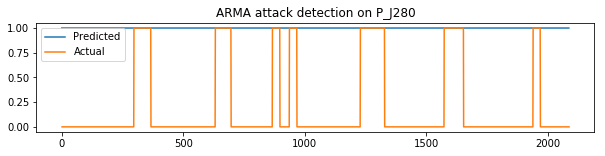

TP: count = 407, list = 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683 684 685 686 687 688 689 690 691 692 693 694 695 696 867 868 869 870 871 872 873 874 875 876 877 878 879 880 881 882 883 884 885 886 887 888 889 890 891 892 893 894 895 896 897 937 938 939 940 941 942 943 944 945 946 947 948 949 950 951 952 953 954 955 956 957 958 959 960 961 962 963 964 965 966 967 1229 1230 1231 1232 1233 1234 1235 1236 1237 1238 1239 1240 1241 1242 1243 1244 1245 1246 1247 1248 1249 1250 1251 1252 1253 1254 1255 1256 1257 1258 1259 1260 1261 1262 1263 1264 1265 126

D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Best ARIMA(4, 0, 2) AIC=40745.753


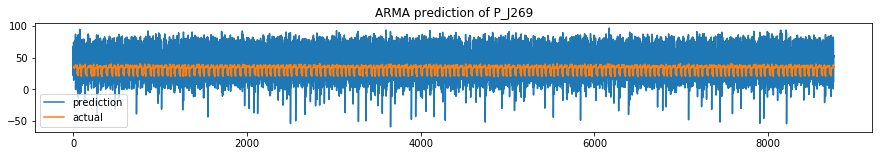

[]


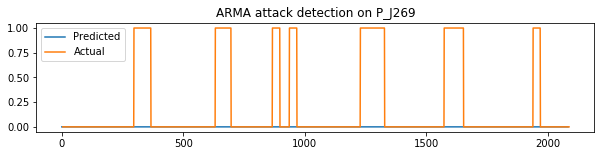

TP: count = 0, list = 
FP: count = 0, list = 
FN: count = 407
precision = 0.000000, recall = 0.000000
---------- FEATURE: P_J300 ---------



D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Best ARIMA(2, 0, 4) AIC=33465.267


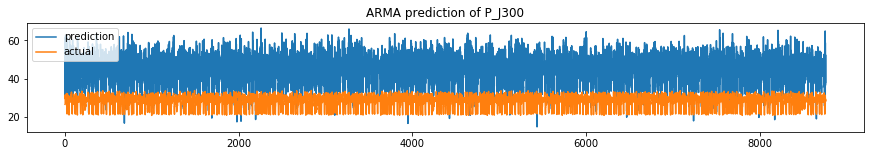

DETECTED residual=42.702 at t=634
DETECTED residual=46.019 at t=642
DETECTED residual=38.197 at t=653
DETECTED residual=43.308 at t=679
DETECTED residual=43.864 at t=1268
DETECTED residual=35.187 at t=1283
[634, 642, 653, 679, 1268, 1283]


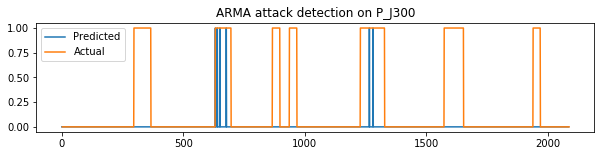

TP: count = 6, list = 634 642 653 679 1268 1283
FP: count = 0, list = 
FN: count = 401
precision = 0.999833, recall = 0.014742
---------- FEATURE: P_J256 ---------



D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Best ARIMA(4, 0, 2) AIC=53818.583


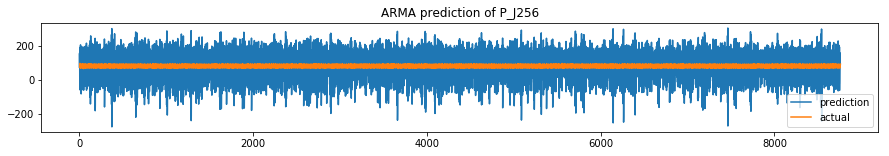

[]


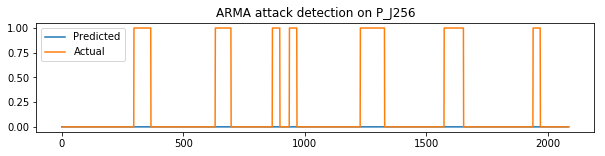

TP: count = 0, list = 
FP: count = 0, list = 
FN: count = 407
precision = 0.000000, recall = 0.000000
---------- FEATURE: P_J289 ---------



D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Best ARIMA(2, 0, 4) AIC=33403.986


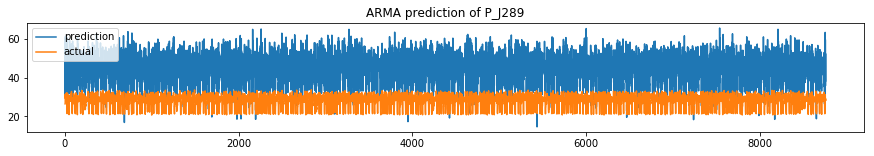

DETECTED residual=41.826 at t=634
DETECTED residual=45.366 at t=642
DETECTED residual=39.304 at t=653
DETECTED residual=42.378 at t=679
DETECTED residual=44.145 at t=1268
DETECTED residual=35.877 at t=1283
[634, 642, 653, 679, 1268, 1283]


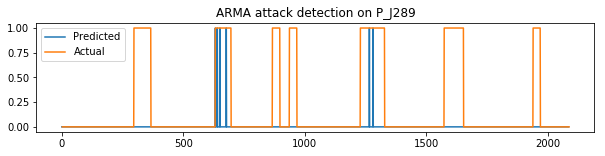

TP: count = 6, list = 634 642 653 679 1268 1283
FP: count = 0, list = 
FN: count = 401
precision = 0.999833, recall = 0.014742
---------- FEATURE: P_J302 ---------



D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Best ARIMA(4, 0, 4) AIC=45309.162


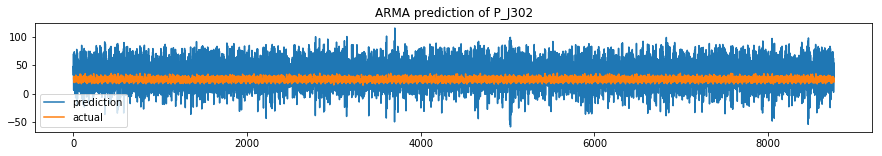

[]


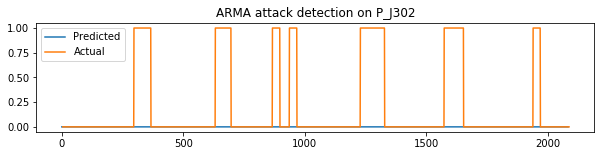

TP: count = 0, list = 
FP: count = 0, list = 
FN: count = 407
precision = 0.000000, recall = 0.000000
---------- FEATURE: P_J306 ---------



D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Best ARIMA(4, 0, 4) AIC=58334.707


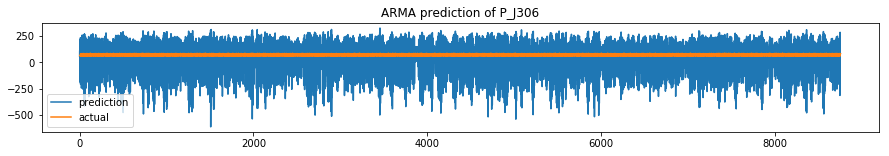

[]


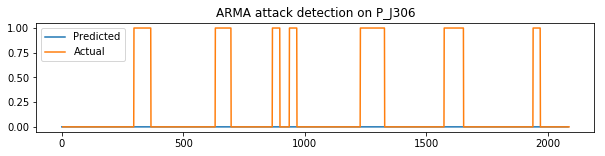

TP: count = 0, list = 
FP: count = 0, list = 
FN: count = 407
precision = 0.000000, recall = 0.000000
---------- FEATURE: P_J307 ---------



D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Best ARIMA(4, 0, 4) AIC=45442.918


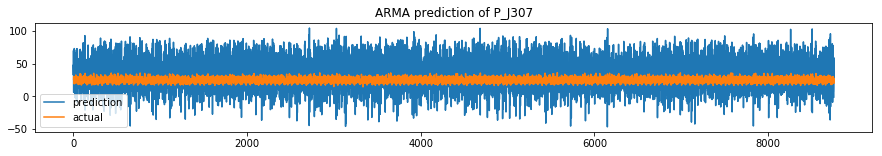

[]


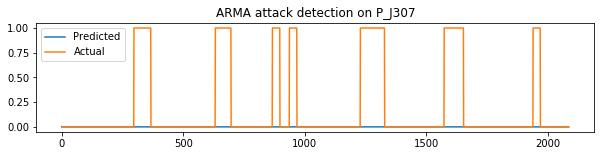

TP: count = 0, list = 
FP: count = 0, list = 
FN: count = 407
precision = 0.000000, recall = 0.000000
---------- FEATURE: P_J317 ---------

Best ARIMA(1, 0, 1) AIC=54176.666


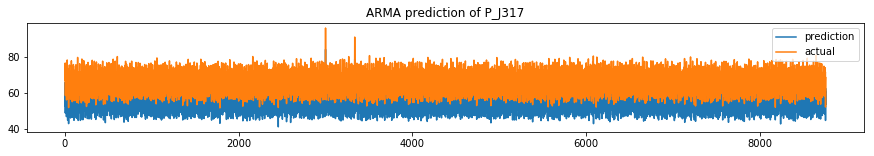

[]


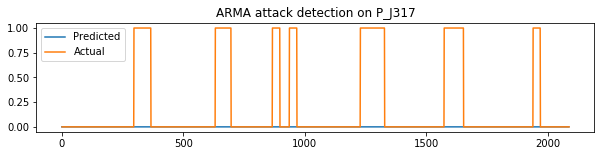

TP: count = 0, list = 
FP: count = 0, list = 
FN: count = 407
precision = 0.000000, recall = 0.000000
---------- FEATURE: P_J14 ---------



D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Best ARIMA(4, 0, 4) AIC=41853.867


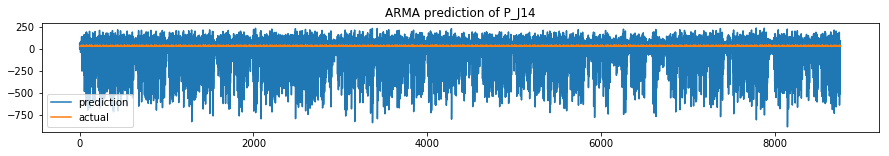

DETECTED residual=917.537 at t=211
[211]


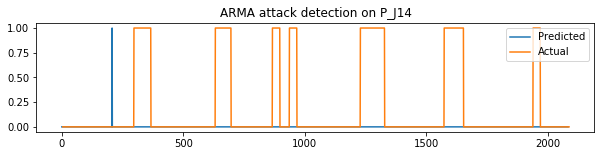

TP: count = 0, list = 
FP: count = 1, list = 211
FN: count = 407
precision = 0.000000, recall = 0.000000
---------- FEATURE: P_J422 ---------



D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Best ARIMA(2, 0, 4) AIC=32499.704


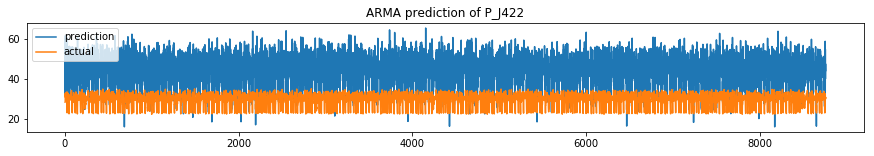

DETECTED residual=38.758 at t=634
DETECTED residual=38.398 at t=642
DETECTED residual=42.283 at t=653
DETECTED residual=37.059 at t=679
DETECTED residual=32.875 at t=1939
[634, 642, 653, 679, 1939]


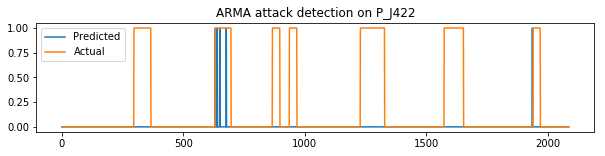

TP: count = 4, list = 634 642 653 679
FP: count = 1, list = 1939
FN: count = 402
precision = 0.799840, recall = 0.009852


In [33]:
# Apply ARMA on junctions
pipeline(junctions_features)